# Iberian outage analysis

We have access to daily data for 2025

In [16]:
import os
import re
import gzip

import pandas as pd
import numpy as np

import ipaddress

import boto3
from botocore.utils import fix_s3_host
from botocore.config import Config

from pathlib import Path

In [20]:
# Load secret environment variables
with open(".env") as f:
    for line in f:
        if line.strip() == '' or line.strip().startswith('#'):
            continue
        key, value = line.strip().split('=', 1)
        os.environ[key] = value

# Set up global constants
DATA_DIR = "data/"
ROWS = 10_000_000

# The date of the data we are using
YEAR = 2025
MONTH = 5
DAY = 1

In [21]:
# Create boto3 resource using environment variables
S3 = boto3.resource(
    's3',
    aws_access_key_id=os.environ['AWS_ACCESS_KEY_ID'],
    aws_secret_access_key=os.environ['AWS_ACCESS_KEY_SECRET'],
    endpoint_url=os.environ['AWS_ENDPOINT_URL'],
    # Change timeouts in case we are uploading large files
    config=Config(
        connect_timeout=3, 
        read_timeout=900, 
        retries={"max_attempts":0}
    )
)

# Unregister to ensure requests don’t go to AWS
S3.meta.client.meta.events.unregister('before-sign.s3', fix_s3_host)

# Use bucket name from environment
HOME_BUCKET = S3.Bucket(os.environ['AWS_BUCKET_NAME'])

In [22]:
# MAnycastR files have metadata that give information about the measurement
def read_gzipped_comment_lines(filepath, comment_char='#'):
    """Read initial comment lines from a gzipped file."""
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"File not found: '{filepath}'")

    try:
        with gzip.open(filepath, 'rt', encoding='utf-8') as f:
            comment_lines = []
            # Read lines until the first non-comment line
            for line in f:
                if line.startswith(comment_char):
                    comment_lines.append(line.rstrip())
                else:
                    # Stop at first non-comment line
                    break
            return comment_lines

    except gzip.BadGzipFile:
        raise gzip.BadGzipFile(f"Invalid gzip file: '{filepath}'")
    except Exception as e:
        raise RuntimeError(f"Error reading file '{filepath}': {e}")

In [23]:
# function to create a hostname mapping (Client ID -> hostname)
def create_hostname_mapping(comment_lines):
    """Map Client ID to hostname from comment lines."""
    pattern = r"ID:\s*(\d+)\s*,\s*hostname:\s*([\w-]+)"
    mapping = {}

    for line in comment_lines:
        if (match := re.search(pattern, line)):
            client_id = int(match.group(1))       # Extract Client ID
            hostname = match.group(2)             # Extract hostname
            mapping[client_id] = hostname

    return mapping

In [24]:
def get_manycast_file(year, month, day, anycast=True, ipv6=False):
    """Download a (Manycast/Unicast, IPv4/IPv6) file from MinIO if not already present."""

    # Build object prefix based on date
    prefix = f"manycast/{year}/{month:02}/{day:02}/"

    # Choose file pattern based on anycast and IP version
    protocol = "ICMPv6" if ipv6 else "ICMPv4"
    base_pattern = f"MAnycast_{protocol}" if anycast else f"GCD_{protocol}"

    # Search for matching file in bucket
    # TEMPORARY because no internet
    return Path("data/MAnycast_ICMPv42025-05-01T01_37_56.csv.gz")
    # for obj in HOME_BUCKET.objects.filter(Prefix=prefix):
    #      # Replace invalid Windows characters in filenames
    #     filename = re.sub(r'[:<>"/\\|?*]', '_', obj.key[len(prefix):])
    #     filepath = os.path.join(DATA_DIR, filename)

    #     if filename.startswith(base_pattern) and filename.endswith('.csv.gz'):
    #         print(f"Found file: {filename} (bucket key: {obj.key})")

    #         # Check if file already exists locally
    #         if os.path.exists(filepath):
    #             print(f"File {filename} already exists. Skipping download.")
    #         else:
    #             print(f"Downloading {filename} from bucket...")
    #             os.makedirs(DATA_DIR, exist_ok=True)
    #             HOME_BUCKET.download_file(obj.key, filepath)

    #         return filepath

    print("No matching file found.")

In [25]:
# Download the file for the specified date
filepath = get_manycast_file(YEAR, MONTH, DAY)

In [26]:
# Get metadata
comment_lines = read_gzipped_comment_lines(filepath)
print("\n".join(comment_lines))

# Completed measurement
# Origin used: Anycast (source IP: 145.116.218.1, source port: 62321, destination port: 63853)
# Hitlist (shuffled): /home/remi/hitlists/v4_20250319.csv
# Measurement type: ICMPv4
# Probing rate: 1,000
# Interval: 1
# Start measurement: 2025-05-01T00_01_04
# End measurement: 2025-05-01T01:37:56
# Measurement length (seconds): 5812.765181
# Connected workers:
# 	 * ID: 22, hostname: ca-yto-manycast
# 	 * ID: 8 , hostname: us-dfw-manycast
# 	 * ID: 9 , hostname: us-lax-manycast
# 	 * ID: 11, hostname: us-hnl-manycast
# 	 * ID: 12, hostname: za-jnb-manycast
# 	 * ID: 16, hostname: au-mel-manycast
# 	 * ID: 17, hostname: fr-cdg-manycast
# 	 * ID: 4 , hostname: de-fra-manycast
# 	 * ID: 20, hostname: il-tlv-manycast
# 	 * ID: 26, hostname: us-sjc-manycast
# 	 * ID: 28, hostname: cl-scl-manycast
# 	 * ID: 36, hostname: in-del-manycast
# 	 * ID: 10, hostname: mx-mex-manycast
# 	 * ID: 23, hostname: us-mia-manycast
# 	 * ID: 32, hostname: au-syd-manycast
# 	 * ID: 29, h

In [27]:
# create hostname mapping
hostname_map = create_hostname_mapping(comment_lines)
hostname_map

{22: 'ca-yto-manycast',
 8: 'us-dfw-manycast',
 9: 'us-lax-manycast',
 11: 'us-hnl-manycast',
 12: 'za-jnb-manycast',
 16: 'au-mel-manycast',
 17: 'fr-cdg-manycast',
 4: 'de-fra-manycast',
 20: 'il-tlv-manycast',
 26: 'us-sjc-manycast',
 28: 'cl-scl-manycast',
 36: 'in-del-manycast',
 10: 'mx-mex-manycast',
 23: 'us-mia-manycast',
 32: 'au-syd-manycast',
 29: 'kr-icn-manycast',
 30: 'jp-nrt-manycast',
 6: 'us-ord-manycast',
 3: 'gb-lhr-manycast',
 2: 'gb-man-manycast',
 25: 'us-sea-manycast',
 1: 'nl-ams-manycast',
 40: 'in-blr-manycast',
 19: 'se-sto-manycast',
 7: 'us-atl-manycast',
 35: 'in-bom-manycast',
 5: 'es-mad-manycast',
 18: 'pl-waw-manycast',
 31: 'jp-itm-manycast',
 21: 'us-ewr-manycast',
 37: 'sg-sgp-manycast',
 39: 'br-sao-manycast'}

In [28]:
# load in data as a pandas dataframe
result_df = pd.read_csv(filepath, skiprows=len(comment_lines), nrows=ROWS, compression='gzip')
result_df.head(10)

,rx_worker_id,reply_src_addr,reply_dst_addr,ttl,rx_time,tx_time,probe_src_addr,probe_dst_addr,tx_worker_id
0,4,351956000,2440354305,114,1746050464071372795,1746050464058266717,2440354305,351956000,1
1,4,1530549521,2440354305,56,1746050464072354271,1746050464057474075,2440354305,1530549521,1
2,4,3113800193,2440354305,59,1746050464074250623,1746050464057071418,2440354305,3113800193,1
3,4,1418227240,2440354305,56,1746050464074910865,1746050464058292799,2440354305,1418227240,1
4,4,3571264001,2440354305,248,1746050464077408232,1746050464057292557,2440354305,3571264001,1
5,4,1565697281,2440354305,56,1746050464081254112,1746050464057444258,2440354305,1565697281,1
6,4,1601134081,2440354305,58,1746050464084453024,1746050464057103555,2440354305,1601134081,1
7,4,1593726977,2440354305,54,1746050464086094665,1746050464057309500,2440354305,1593726977,1
8,4,2989529109,2440354305,52,1746050464087848367,1746050464057480154,2440354305,2989529109,1
9,4,1425815553,2440354305,248,1746050464088817081,1746050464057498068,2440354305,1425815553,1


In [29]:
# probe_src_addr is equal to reply_dst_addr
# for row in range(len(result_df["reply_dst_addr"])):
#     if result_df["reply_dst_addr"].iloc[row] != result_df["probe_src_addr"].iloc[row]:
#         print(row)
#         break
# else:
#     print("equal!")

In [30]:
# the source address is the same everytime (as it should in a anycast environment)
# print(result_df[result_df["reply_dst_addr"] != 2440354305])

In [31]:
# data cleaning as we are only using the following columns:
result_df = result_df[['rx_worker_id', 'tx_worker_id', 'reply_src_addr', 'rx_time', 'tx_time', 'ttl']]
result_df.head(10)

,rx_worker_id,tx_worker_id,reply_src_addr,rx_time,tx_time,ttl
0,4,1,351956000,1746050464071372795,1746050464058266717,114
1,4,1,1530549521,1746050464072354271,1746050464057474075,56
2,4,1,3113800193,1746050464074250623,1746050464057071418,59
3,4,1,1418227240,1746050464074910865,1746050464058292799,56
4,4,1,3571264001,1746050464077408232,1746050464057292557,248
5,4,1,1565697281,1746050464081254112,1746050464057444258,56
6,4,1,1601134081,1746050464084453024,1746050464057103555,58
7,4,1,1593726977,1746050464086094665,1746050464057309500,54
8,4,1,2989529109,1746050464087848367,1746050464057480154,52
9,4,1,1425815553,1746050464088817081,1746050464057498068,248


In [33]:
# we scan an address in each /24 prefix, which is representative of that prefix
# each target is scanned by all 32 anycast sites
# in your case this might give redundancy, so make sure to take into consideration that you will see the same prefix multiple times (e.g., remove duplicate targets from the analysis)

# convert IP-number to ip network
result_df['target'] = result_df['reply_src_addr'].apply(
    # can be sped up with swifter
    lambda x: ipaddress.ip_network(f"{ipaddress.ip_address(x)}/24", strict=False)
)

# get receiving anycast site
result_df['receiver'] = result_df['rx_worker_id'].map(hostname_map)

# get sending anycast site
result_df['sender'] = result_df['tx_worker_id'].map(hostname_map)

# calculate rtt
result_df['rtt'] = ((result_df['rx_time'] - result_df['tx_time']) / 1e6)

# drop unnecessary columns
result_df = result_df[['receiver', 'sender', 'target', 'rtt', 'ttl']]

print(len(result_df["target"].unique()))

result_df.head(10)

325488


,receiver,sender,target,rtt,ttl
0,de-fra-manycast,nl-ams-manycast,20.250.108.0/24,13.106078,114
1,de-fra-manycast,nl-ams-manycast,91.58.85.0/24,14.880196,56
2,de-fra-manycast,nl-ams-manycast,185.152.210.0/24,17.179205,59
3,de-fra-manycast,nl-ams-manycast,84.136.110.0/24,16.618066,56
4,de-fra-manycast,nl-ams-manycast,212.221.42.0/24,20.115675,248
5,de-fra-manycast,nl-ams-manycast,93.82.165.0/24,23.809854,56
6,de-fra-manycast,nl-ams-manycast,95.111.94.0/24,27.349469,58
7,de-fra-manycast,nl-ams-manycast,94.254.88.0/24,28.785165,54
8,de-fra-manycast,nl-ams-manycast,178.48.152.0/24,30.368213,52
9,de-fra-manycast,nl-ams-manycast,84.252.56.0/24,31.319013,248


**Some ideas:**
- what is the impact on average hop count (TTL)?
- what is the impact on average RTT?
- which prefixes became unreachable?
- which prefixes shifted catchment?
- where did the prefixes that switched catchment go?

Also consider looking at GCD and filtering on sender == madrid -> how many prefixes are reachable from there?

# Work for project
## geolocate ip addresses
We may not be able to map all addresses, due to IPs missing in the geolocation database.
Also the IP may be missing or wrongly geolocated, due to changes over time (however the prefixes generally should stay in a certain region (maybe find a source for this claim)).

In [15]:
# IMPORTS & VARIABLES
from pathlib import Path
import os
import gzip
import re
import ipaddress
import zipfile

import pandas as pd
import numpy as np

import requests

IP_GEOLOCATION_DB_PATH = Path("data/IP2LOCATION-LITE-DB5.CSV")
IP_GEOLOCATION_DOWNLOAD_PATH = Path("data/ip2location-lite-db5.zip")
IP_GEOLOCATION_URL = f"https://www.ip2location.com/download/?token={os.environ["IP2LOCATION_LITE_TOKEN"]}&file=DB5LITECSV"
MANYCAST_DATA_PATH = Path("data/MAnycast_ICMPv42025-05-01T01_37_56.csv.gz")
ROWS = 1_000_000

In [16]:
def download_ip2location_db():
    # retrieve ip2location database
    if not IP_GEOLOCATION_DB_PATH.exists():
        # download
        response = requests.get(IP_GEOLOCATION_URL, allow_redirects=True)
        if not response.ok:
            print("Download of IP2Location database failed!")
            return     
        with open(IP_GEOLOCATION_DOWNLOAD_PATH, "wb") as f:
            f.write(response.content)
        
        # extract
        with zipfile.ZipFile(IP_GEOLOCATION_DOWNLOAD_PATH, "r") as zipf:
            zipf.extractall("data")
        
        os.remove(IP_GEOLOCATION_DOWNLOAD_PATH)

In [17]:
download_ip2location_db()

In [18]:
# function to create a hostname mapping (Client ID -> hostname)
def create_hostname_mapping(comment_lines):
    """Map Client ID to hostname from comment lines."""
    pattern = r"ID:\s*(\d+)\s*,\s*hostname:\s*([\w-]+)"
    mapping = {}

    for line in comment_lines:
        if (match := re.search(pattern, line)):
            client_id = int(match.group(1))       # Extract Client ID
            hostname = match.group(2)             # Extract hostname
            mapping[client_id] = hostname

    return mapping

In [19]:
# MAnycastR files have metadata that give information about the measurement
def read_gzipped_comment_lines(filepath, comment_char='#'):
    """Read initial comment lines from a gzipped file."""
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"File not found: '{filepath}'")

    try:
        with gzip.open(filepath, 'rt', encoding='utf-8') as f:
            comment_lines = []
            # Read lines until the first non-comment line
            for line in f:
                if line.startswith(comment_char):
                    comment_lines.append(line.rstrip())
                else:
                    # Stop at first non-comment line
                    break
            return comment_lines

    except gzip.BadGzipFile:
        raise gzip.BadGzipFile(f"Invalid gzip file: '{filepath}'")
    except Exception as e:
        raise RuntimeError(f"Error reading file '{filepath}': {e}")

In [20]:
# Preprocessing of MAnycast data
comment_lines = read_gzipped_comment_lines(MANYCAST_DATA_PATH)
print("\n".join(comment_lines))
hostname_map = create_hostname_mapping(comment_lines)

# load in data as a pandas dataframe
result_df = pd.read_csv(MANYCAST_DATA_PATH, skiprows=len(comment_lines), nrows=ROWS, compression='gzip')

# reduce to relevant columns
result_df = result_df[['rx_worker_id', 'tx_worker_id', 'reply_src_addr', 'rx_time', 'tx_time', 'ttl']]

# convert IP-number to ip network
result_df['target'] = result_df['reply_src_addr'].apply(
    # can be sped up with swifter
    lambda x: ipaddress.ip_network(f"{ipaddress.ip_address(x)}/24", strict=False)
)

# get receiving anycast site
result_df['receiver'] = result_df['rx_worker_id'].map(hostname_map)

# get sending anycast site
result_df['sender'] = result_df['tx_worker_id'].map(hostname_map)

# calculate rtt
result_df['rtt'] = ((result_df['rx_time'] - result_df['tx_time']) / 1e6)

# drop unnecessary columns
result_df = result_df[['receiver', 'sender', 'target', 'reply_src_addr', 'rtt', 'ttl']]

# create column to check whether a target is in the location database
result_df.insert(result_df.shape[1], "isin_ip2location_db", False)


# Completed measurement
# Origin used: Anycast (source IP: 145.116.218.1, source port: 62321, destination port: 63853)
# Hitlist (shuffled): /home/remi/hitlists/v4_20250319.csv
# Measurement type: ICMPv4
# Probing rate: 1,000
# Interval: 1
# Start measurement: 2025-05-01T00_01_04
# End measurement: 2025-05-01T01:37:56
# Measurement length (seconds): 5812.765181
# Connected workers:
# 	 * ID: 22, hostname: ca-yto-manycast
# 	 * ID: 8 , hostname: us-dfw-manycast
# 	 * ID: 9 , hostname: us-lax-manycast
# 	 * ID: 11, hostname: us-hnl-manycast
# 	 * ID: 12, hostname: za-jnb-manycast
# 	 * ID: 16, hostname: au-mel-manycast
# 	 * ID: 17, hostname: fr-cdg-manycast
# 	 * ID: 4 , hostname: de-fra-manycast
# 	 * ID: 20, hostname: il-tlv-manycast
# 	 * ID: 26, hostname: us-sjc-manycast
# 	 * ID: 28, hostname: cl-scl-manycast
# 	 * ID: 36, hostname: in-del-manycast
# 	 * ID: 10, hostname: mx-mex-manycast
# 	 * ID: 23, hostname: us-mia-manycast
# 	 * ID: 32, hostname: au-syd-manycast
# 	 * ID: 29, h

In [21]:
# read the ip2location lite database
ip_location_db = pd.read_csv(IP_GEOLOCATION_DB_PATH, skiprows=1, names=["ip_from", "ip_to", "country_code", "country_name", "region", "city", "lat", "lon"])

In [22]:
# check whether the ips in ip_location_db are continous discrete
# for idx in ip_location_db.index:
#     if (idx + 1) < len(ip_location_db) and ip_location_db.loc[idx, "ip_to"] + 1 != ip_location_db.loc[idx + 1, "ip_from"]:
#        print(f"non_continous at row {idx}!")
#        break

In [23]:
# exclude first and last row, as those do not contain relevant numbers
ip_location_db = ip_location_db.iloc[1:-1, :]
first_addr_in_db = ip_location_db.loc[1, "ip_from"]
last_addr_in_db = ip_location_db.loc[len(ip_location_db) - 1, "ip_to"]

# as the ip ranges of the ip_location_db are continous discrete the check whether an target address is in the ip_location_db can be simplified
result_df["isin_ip2location_db"] = (result_df["reply_src_addr"] >= first_addr_in_db) & (result_df["reply_src_addr"] <= last_addr_in_db)

In [24]:
print(ip_location_db)
print(result_df)

            ip_from       ip_to country_code country_name      region  \
1          16777472    16778239           CN        China      Fujian   
2          16778240    16778495           AU    Australia    Victoria   
3          16778496    16778751           AU    Australia  Queensland   
4          16778752    16779007           AU    Australia    Victoria   
5          16779008    16779263           AU    Australia  Queensland   
...             ...         ...          ...          ...         ...   
3025555  3758093312  3758094335           IN        India     Gujarat   
3025556  3758094336  3758095359           HK    Hong Kong   Hong Kong   
3025557  3758095360  3758095871           CN        China      Fujian   
3025558  3758095872  3758096127           SG    Singapore   Singapore   
3025559  3758096128  3758096383           AU    Australia  Queensland   

              city        lat         lon  
1           Fuzhou  26.061390  119.306110  
2        Melbourne -37.814007  144.

In [25]:
# calculate the amount of found ip addresses in the ip2location data
print("Amount of IP addresses not found in geolocation database:", len(result_df[result_df["isin_ip2location_db"] == False]))
# check whether the geolocation database has invalid lat long values for any entries in (first + 1, last - 1)
lat0_lon0_amount = ((ip_location_db["lon"] == 0.0) & (ip_location_db["lat"] == 0.0)).sum()
print("invalid lat long values found in ip2location: ", lat0_lon0_amount)

Amount of IP addresses not found in geolocation database: 0
invalid lat long values found in ip2location:  6181


In [26]:
# Sort ip_location_db by 'ip_from'
ip_location_db = ip_location_db.sort_values("ip_from")

result_df = result_df.sort_values("reply_src_addr")

# merge_asof for efficient range join
merged = None
if not merged:
    merged = pd.merge_asof(
        result_df,
        ip_location_db,
        left_on="reply_src_addr",
        right_on="ip_from",
        direction="backward"
    )

# filter entry when reply_src_addr > ip_to
merged = merged[merged["reply_src_addr"] <= merged["ip_to"]]

if not ("lat" in result_df.columns or "lon" in result_df.columns):
    result_df.insert(len(result_df.columns), "lat", 0.0)
    result_df.insert(len(result_df.columns), "lon", 0.0)

result_df["lat"] = merged["lat"].values
result_df["lon"] = merged["lon"].values

In [27]:
# check for invalid values of lat lon with regard to target_ips
print(result_df[(result_df["lat"] == 0.0) & (result_df["lon"] == 0.0)].shape[0])

21


In [28]:
print(result_df)

               receiver           sender           target  reply_src_addr  \
955117  jp-nrt-manycast  us-hnl-manycast     1.0.155.0/24        16816906   
871163  jp-nrt-manycast  us-atl-manycast     1.0.155.0/24        16816906   
829173  jp-nrt-manycast  es-mad-manycast     1.0.155.0/24        16816906   
913204  jp-nrt-manycast  us-lax-manycast     1.0.155.0/24        16816906   
808194  jp-nrt-manycast  de-fra-manycast     1.0.155.0/24        16816906   
...                 ...              ...              ...             ...   
887293  jp-itm-manycast  in-bom-manycast  223.253.95.0/24      3757924135   
656822  jp-itm-manycast  il-tlv-manycast  223.253.95.0/24      3757924135   
342985  jp-itm-manycast  gb-man-manycast  223.253.95.0/24      3757924135   
553284  jp-itm-manycast  za-jnb-manycast  223.253.95.0/24      3757924135   
616089  jp-itm-manycast  pl-waw-manycast  223.253.95.0/24      3757924135   

               rtt  ttl  isin_ip2location_db        lat         lon  
95511

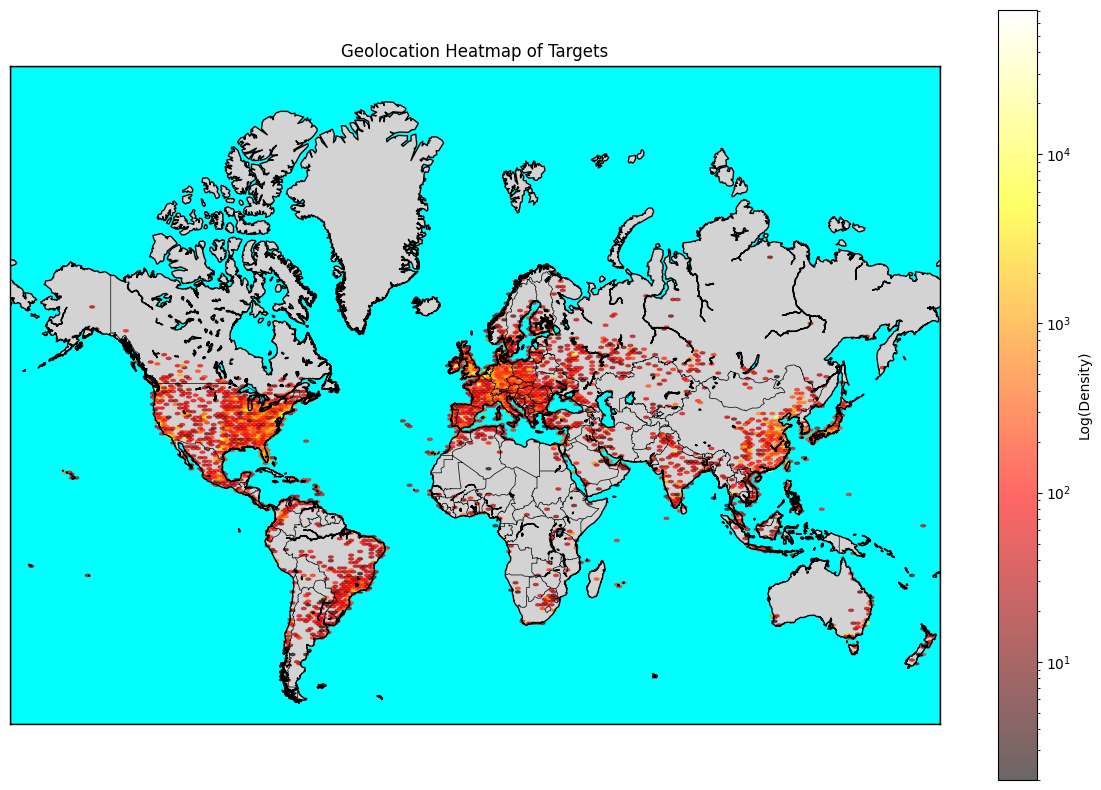

In [30]:
# Chatgpt generated, first boilerplate
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np

# Drop rows with missing or zero coordinates
geo_df = result_df[(result_df["lat"] != 0.0) & (result_df["lon"] != 0.0)].copy()

# Prepare coordinates
lats = geo_df["lat"].values
lons = geo_df["lon"].values

# Set up figure
plt.figure(figsize=(15, 10))

# Initialize Basemap
m = Basemap(projection='merc',
            llcrnrlat=-60, urcrnrlat=85,
            llcrnrlon=-180, urcrnrlon=180,
            resolution='l')

# Draw map details
m.drawcoastlines()
m.drawcountries()
m.drawmapboundary(fill_color='aqua')
m.fillcontinents(color='lightgray', lake_color='aqua')

# Project coordinates
x, y = m(lons, lats)

# Create heatmap using hexbin
m.hexbin(x, y, gridsize=200, bins='log', cmap='hot', alpha=0.6)

# Add colorbar and title
plt.colorbar(label='Log(Density)')
plt.title('Geolocation Heatmap of Targets')
plt.show()